<a href="https://colab.research.google.com/github/mutabazichristian/water-quality-model/blob/christian/dropout%26reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
import seaborn as sns


In [124]:
np.random.seed(42)
tf.random.set_seed(42)

In [125]:
drive.mount('/content/drive')
dataset = pd.read_csv('/content/drive/MyDrive/ALU/datasets/water_potability.csv')
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [127]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [128]:
smote_tomek = SMOTETomek(random_state=42, sampling_strategy=0.65)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

In [129]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_resampled.shape[1],)),
    tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l1(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l1(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l1(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l1(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [130]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

optimizer = tf.keras.optimizers.RMSprop(
    #learning_rate=lr_schedule,
    rho=0.9,
    momentum=0.1,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

In [131]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    min_delta=0.001,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

In [132]:
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_test_scaled, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5301 - loss: 1.0847 - val_accuracy: 0.6311 - val_loss: 0.9827 - learning_rate: 0.0010
Epoch 2/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6155 - loss: 1.0024 - val_accuracy: 0.6418 - val_loss: 0.9622 - learning_rate: 0.0010
Epoch 3/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6080 - loss: 0.9893 - val_accuracy: 0.6570 - val_loss: 0.9445 - learning_rate: 0.0010
Epoch 4/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6437 - loss: 0.9624 - val_accuracy: 0.6768 - val_loss: 0.9297 - learning_rate: 0.0010
Epoch 5/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6632 - loss: 0.9456 - val_accuracy: 0.6905 - val_loss: 0.9190 - learning_rate: 0.0010
Epoch 6/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6507 - loss: 0.9328 - val_accuracy: 0.6799 - val_loss: 0.9143 - learning_rate: 0.0010
Epoch 7/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6700 - loss: 0.9219 - val_ac

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.87      0.76       400
           1       0.64      0.35      0.45       256

    accuracy                           0.67       656
   macro avg       0.66      0.61      0.61       656
weighted avg       0.66      0.67      0.64       656

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6648 - loss: 0.7563 

Test Accuracy: 0.6692073345184326
F1 Score: 0.4534005037783375
Precision: 0.6382978723404256
Recall: 0.3515625
[[349  51]
 [166  90]]


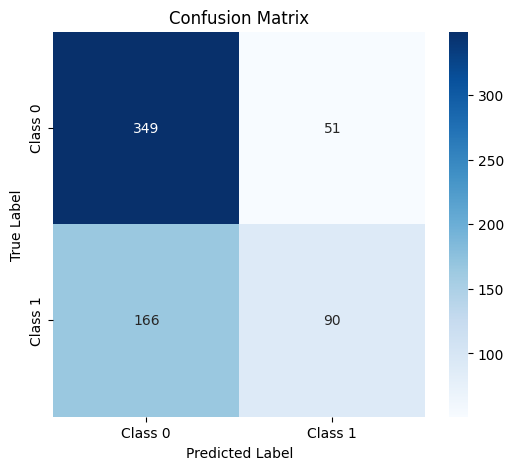

In [133]:
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nTest Accuracy: {accuracy}")
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()